**Quadcopter Dynamics Equations**

In [382]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

params = {
    'mass': 0.8644,  # kg
    'gravity': 9.81,  # m/s^2
    'inertia': [0.0004929, 0.0004929, 2*0.0004929],  # kg·m^2 (I_x, I_y, I_z)
    'arm_length': 0.089,  # m
    'thrust_coefficient': 1e-5,
    'drag_coefficient': 1e-7,
}

def rotation_matrix(phi, theta, psi):
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    R_y = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    R_z = np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi), np.cos(psi), 0],
        [0, 0, 1]
    ])
    return R_z @ R_y @ R_x

# This function relates the torques and Thrust with the omega values of the quadcopter
def compute_rotor_speeds(T, tau_phi, tau_theta, tau_psi, params):
    """
    Compute rotor speeds from T, tau_phi, tau_theta, tau_psi using the given params.
    The relationship is given by:
      [ T          ]   [ k_t        k_t       k_t        k_t     ] [w_1^2]
      [ tau_phi    ] = [ 0         -l*k_t     0         l*k_t    ] [w_2^2]
      [ tau_theta  ]   [-l*k_t      0         l*k_t      0       ] [w_3^2]
      [ tau_psi    ]   [-k_d        k_d      -k_d        k_d     ] [w_4^2]

    Solve this linear system for w_i^2 and then take square roots to get w_i.
    """
    k_t = params['thrust_coefficient']
    k_d = params['drag_coefficient']
    l = params['arm_length']

    M = np.array([
        [k_t,      k_t,      k_t,      k_t],
        [0,       -l*k_t,    0,       l*k_t],
        [-l*k_t,   0,        l*k_t,    0],
        [-k_d,     k_d,     -k_d,      k_d]
    ])

    b = np.array([T, tau_phi, tau_theta, tau_psi])
    w_sq = np.linalg.solve(M, b)
    w_sq = np.maximum(w_sq, 0.0)
    return np.sqrt(w_sq)

def translational_dynamics(state, input, params):
    m = params['mass']
    g = params['gravity']
    phi, theta, psi = state[6], state[7], state[8]
    T, tau_phi, tau_theta, tau_psi = input

    F_body = np.array([0, 0, T])
    R_BW = rotation_matrix(phi, theta, psi)
    F_inertial = R_BW @ F_body
    F_inertial[2] -= m * g
    return F_inertial / m

def rotational_dynamics(state, input, params):
    I_x, I_y, I_z = params['inertia']
    p, q, r = state[9], state[10], state[11]
    T, tau_phi, tau_theta, tau_psi = input

    p_dot = (tau_phi + (I_y - I_z) * q * r) / I_x
    q_dot = (tau_theta + (I_z - I_x) * p * r) / I_y
    r_dot = (tau_psi + (I_x - I_y) * p * q) / I_z
    return np.array([p_dot, q_dot, r_dot])

def dynamics(t, state, input, params):
    a_inertial = translational_dynamics(state, input, params)
    angular_accels = rotational_dynamics(state, input, params)

    return np.array([
        state[3], state[4], state[5],        # dx/dt, dy/dt, dz/dt
        a_inertial[0], a_inertial[1], a_inertial[2], # du/dt, dv/dt, dw/dt
        state[9], state[10], state[11],       # dphi/dt, dtheta/dt, dpsi/dt
        angular_accels[0], angular_accels[1], angular_accels[2] # dp/dt, dq/dt, dr/dt
    ])

**Challange #1**

Hovering

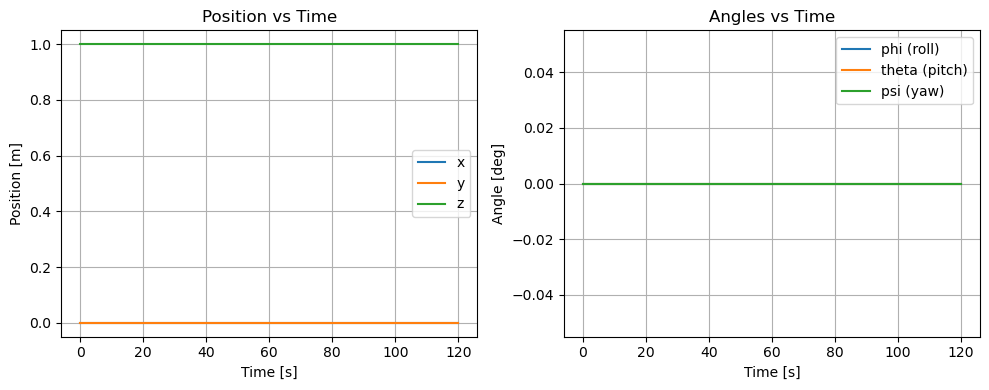

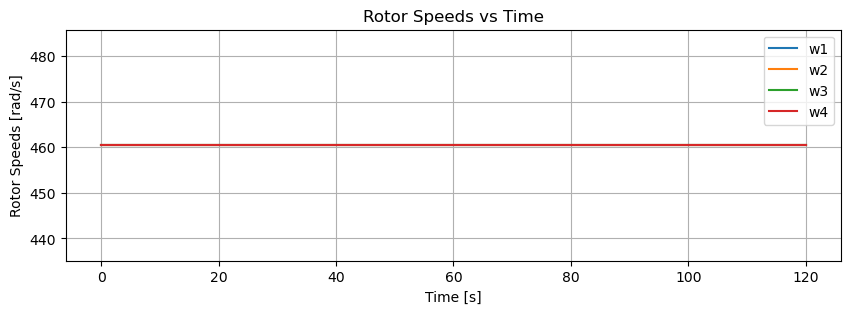

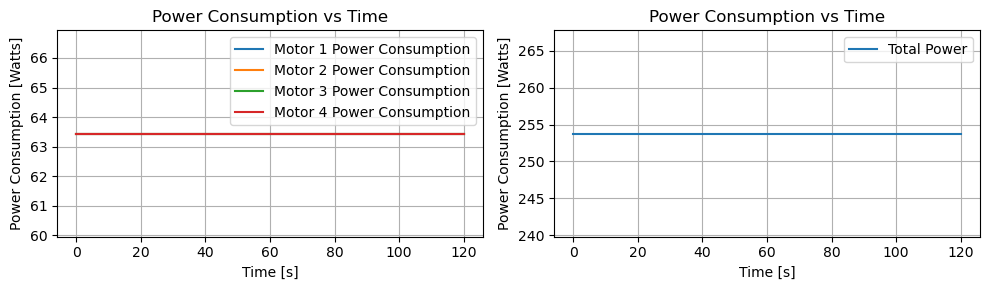

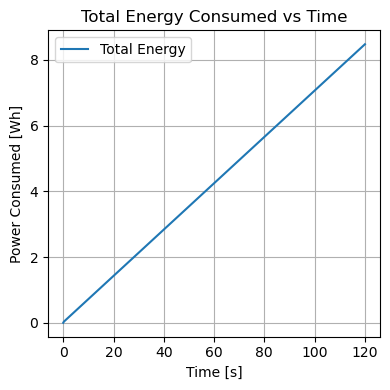

In [383]:
input = [params['gravity'] * params['mass'], 0, 0, 0]
initial_state = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

t_span = (0, 120)
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Solve the dynamics
sol = solve_ivp(dynamics, t_span, initial_state, t_eval=t_eval, args=(input, params))

x = sol.y[0, :]
y = sol.y[1, :]
z = sol.y[2, :]
phi = sol.y[6, :]
theta = sol.y[7, :]
psi = sol.y[8, :]

# Position
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(sol.t, x, label='x')
plt.plot(sol.t, y, label='y')
plt.plot(sol.t, z, label='z')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position vs Time')
plt.grid(True)
plt.legend()

# Anlges
plt.subplot(1,2,2)
plt.plot(sol.t, np.degrees(phi), label='phi (roll)')
plt.plot(sol.t, np.degrees(theta), label='theta (pitch)')
plt.plot(sol.t, np.degrees(psi), label='psi (yaw)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.title('Angles vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

'''------------------------------------------------------------------------------------'''

def compute_rotor_speeds_over_time(sol, params):
    w_all = []
    for i in range(len(sol.t)):
        T, tau_phi, tau_theta, tau_psi = input
        w = compute_rotor_speeds(T, tau_phi, tau_theta, tau_psi, params)
        w_all.append(w)
    w_all = np.array(w_all).T 
    return sol.t, w_all[0,:], w_all[1,:], w_all[2,:], w_all[3,:]

def plot_rotor_speeds(t, w1, w2, w3, w4):

    plt.figure(figsize=(10,3))
    plt.plot(t, w1, label='w1')
    plt.plot(t, w2, label='w2')
    plt.plot(t, w3, label='w3')
    plt.plot(t, w4, label='w4')
    plt.xlabel('Time [s]')
    plt.ylabel('Rotor Speeds [rad/s]')
    plt.title('Rotor Speeds vs Time')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_power(t, w1, w2, w3, w4):
    w = np.array([w1,w2,w3,w4])
    p_motors = []
    for i in range(len(w)):
        power = 0.13 * w[i]**3 * params['thrust_coefficient'] / 2
        p_motors.append(power)
    total = np.sum(p_motors, axis=0)

    energy_vals = np.cumsum(total) * (np.diff(t, prepend=t[0]) / 3600)
    

    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(t, p_motors[0], label='Motor 1 Power Consumption')
    plt.plot(t, p_motors[1], label='Motor 2 Power Consumption')
    plt.plot(t, p_motors[2], label='Motor 3 Power Consumption')
    plt.plot(t, p_motors[3], label='Motor 4 Power Consumption')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumption [Watts]')
    plt.title('Power Consumption vs Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(t, total, label='Total Power')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumption [Watts]')
    plt.title('Power Consumption vs Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,4))
    plt.plot(t, energy_vals, label='Total Energy')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumed [Wh]')
    plt.title('Total Energy Consumed vs Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


t, w1, w2, w3, w4 = compute_rotor_speeds_over_time(sol, params)
plot_rotor_speeds(t, w1, w2, w3, w4)
plot_power(t, w1, w2, w3, w4)


**Challange #2**

Hovering in a Circular Pattern

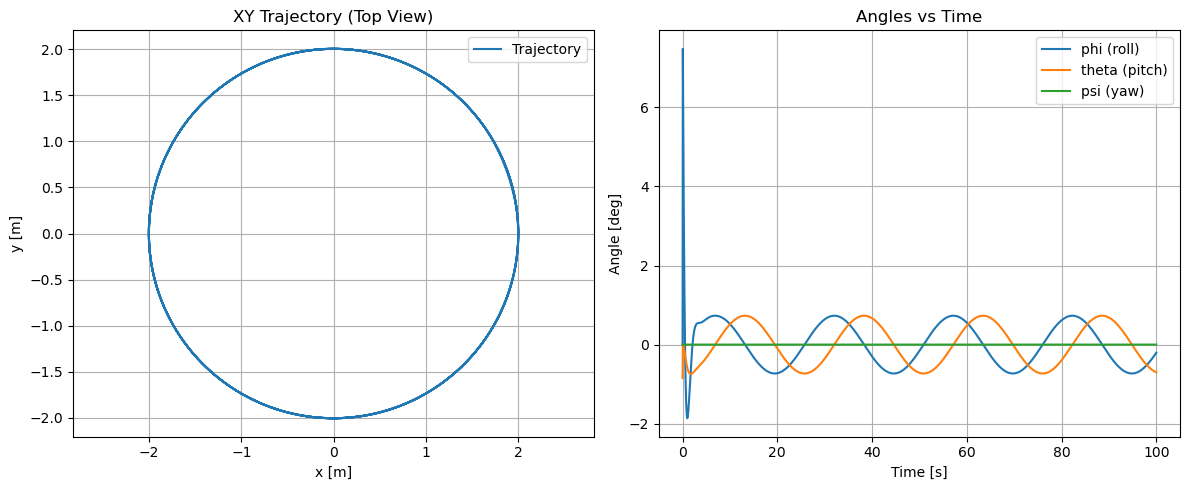

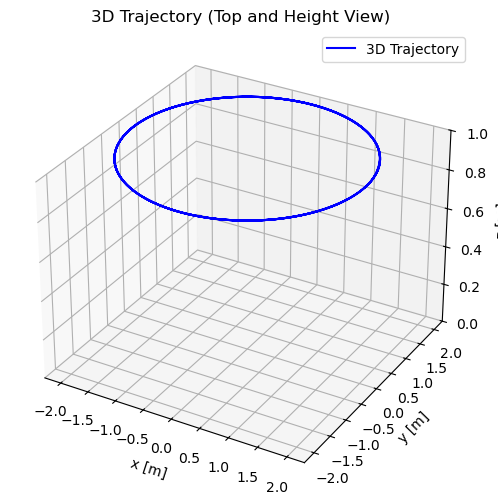

In [384]:
def controller(t, state, params):
    R = 2      
    omega = 0.5 / R   # angular speed (rad/s)
    z_ref = 1
    psi_ref = 0.0

    x, y, z = state[0], state[1], state[2]
    u, v, w = state[3], state[4], state[5]
    phi, theta, psi = state[6], state[7], state[8]
    p, q, r = state[9], state[10], state[11]

    x_ref = R * np.cos(omega * t)
    y_ref = R * np.sin(omega * t)

    Kp_xy = 0.5
    Kd_xy = 0.3
    
    Kp_z = 10
    Kd_z = 5.0
    T = params['mass']*params['gravity'] + Kp_z*(z_ref - z) + Kd_z*(0 - w)
    a_des_x = Kp_xy*(x_ref - x) + Kd_xy*(0 - u)
    a_des_y = Kp_xy*( y_ref - y) + Kd_xy*(0 - v)
    # Linearization
    phi_des = -a_des_y
    theta_des = a_des_x

    Kp_angle = 2000
    Kd_angle = 5

    # Compute torques
    tau_phi = Kp_angle*(phi_des - phi) + Kd_angle*(0 - p)
    tau_theta = Kp_angle*(theta_des - theta) + Kd_angle*(0 - q)
    tau_psi = Kp_angle*(psi_ref - psi) + Kd_angle*(0 - r)

    return [T, tau_phi, tau_theta, tau_psi]

def dynamics_with_control(t, state, params):
    input = controller(t, state, params)
    return dynamics(t, state, input, params)

centripetal_acceleration = 0.5**2 / R
downwards = params['mass'] * params['gravity']
ang = np.pi/2 - np.arctan2(downwards,centripetal_acceleration)
initial_state = [2, 0, 1, 0, 0.5, 0, 0, -ang, 0, 0, 0, 0] 

t_span = (0, 100)
t_eval = np.linspace(0, 100, 2000)
sol = solve_ivp(dynamics_with_control, t_span, initial_state, t_eval=t_eval, args=(params,))

x = sol.y[0,:]
y = sol.y[1,:]
z = sol.y[2,:]
phi = sol.y[6,:]
theta = sol.y[7,:]
psi = sol.y[8,:]

dphi = sol.y[9,:]
dtheta = sol.y[10,:]
dpsi = sol.y[11,:]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, y, label='Trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY Trajectory (Top View)')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(sol.t, np.degrees(phi), label='phi (roll)')
plt.plot(sol.t, np.degrees(theta), label='theta (pitch)')
plt.plot(sol.t, np.degrees(psi), label='psi (yaw)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.title('Angles vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d') 
ax.plot(x, y, z, label='3D Trajectory', color='blue')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D Trajectory (Top and Height View)')
ax.set_zlim(0, 1)
ax.grid(True)
ax.legend()

plt.show()


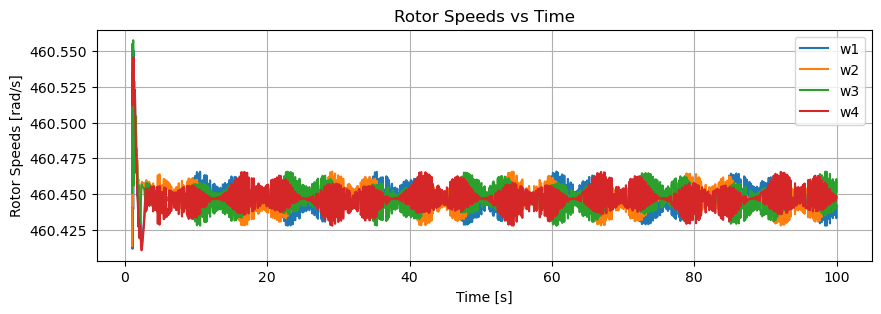

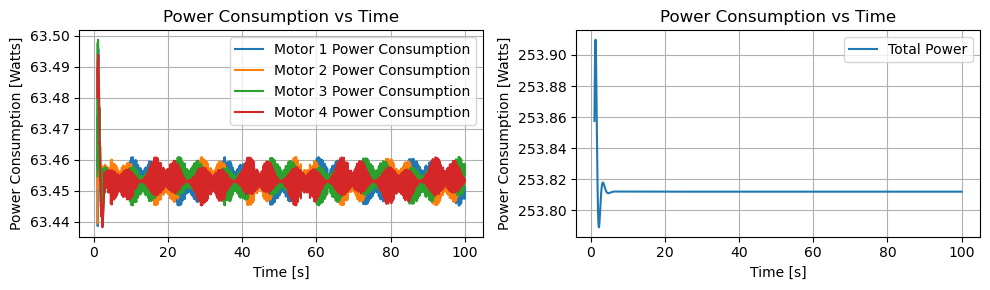

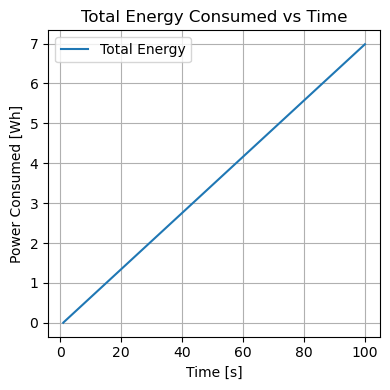

In [385]:

def compute_rotor_speeds_over_time(sol, params):
    """
    Using the solution 'sol' from solve_ivp and the given params, this function:
    - Calls the controller at each time step to get (T, tau_phi, tau_theta, tau_psi).
    - Computes the corresponding rotor speeds at each time.
    Returns time array and a 2D array of shape (4, len(sol.t)) with rotor speeds.
    """
    w_all = []
    for i, t in enumerate(sol.t):
        if t > 1:
            state = sol.y[:, i]
            T, tau_phi, tau_theta, tau_psi = controller(t, state, params)
            w = compute_rotor_speeds(T, tau_phi, tau_theta, tau_psi, params)
            w_all.append(w)
        else:
            w_all.append(np.array([1850,1850,1850,1850]))

    w_all = np.array(w_all).T 
    return sol.t, w_all[0,:], w_all[1,:], w_all[2,:], w_all[3,:]


def plot_rotor_speeds(t, w1, w2, w3, w4):
    """
    Plot rotor speeds for the four motors over time.
    """
    plt.figure(figsize=(10,3))
    plt.plot(t, w1, label='w1')
    plt.plot(t, w2, label='w2')
    plt.plot(t, w3, label='w3')
    plt.plot(t, w4, label='w4')
    plt.xlabel('Time [s]')
    plt.ylabel('Rotor Speeds [rad/s]')
    plt.title('Rotor Speeds vs Time')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_power(t, w1, w2, w3, w4):
    w = np.array([w1,w2,w3,w4])
    p_motors = []
    for i in range(len(w)):
        power = 0.13 * w[i]**3 * params['thrust_coefficient'] / 2
        p_motors.append(power)
    total = np.sum(p_motors, axis=0)


    energy_vals = np.cumsum(total) * (np.diff(t, prepend=t[0]) / 3600)

    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(t, p_motors[0], label='Motor 1 Power Consumption')
    plt.plot(t, p_motors[1], label='Motor 2 Power Consumption')
    plt.plot(t, p_motors[2], label='Motor 3 Power Consumption')
    plt.plot(t, p_motors[3], label='Motor 4 Power Consumption')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumption [Watts]')
    plt.title('Power Consumption vs Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(t, total, label='Total Power')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumption [Watts]')
    plt.title('Power Consumption vs Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,4))
    plt.plot(t, energy_vals, label='Total Energy')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumed [Wh]')
    plt.title('Total Energy Consumed vs Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

t, w1, w2, w3, w4 = compute_rotor_speeds_over_time(sol, params)
mask = t > 0.96
t = t[mask]
w1 = w1[mask]
w2 = w2[mask]
w3 = w3[mask]
w4 = w4[mask]
plot_rotor_speeds(t, w1, w2, w3, w4)
plot_power(t, w1, w2, w3, w4)



**Bonus Challange**

Extra Credit

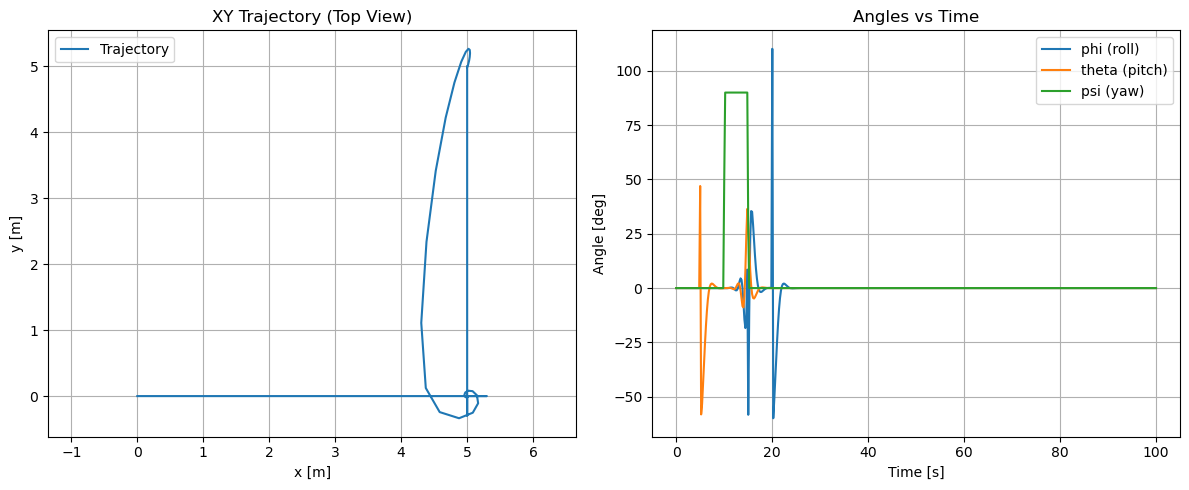

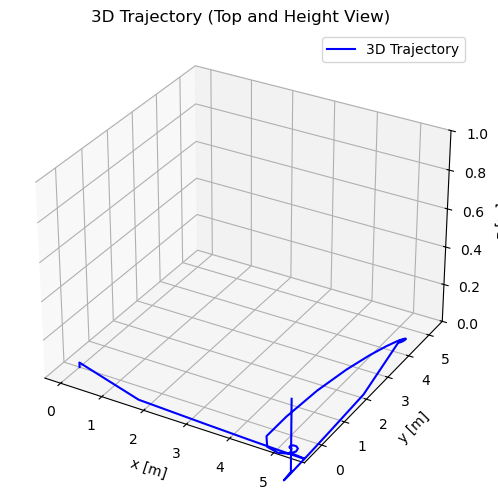

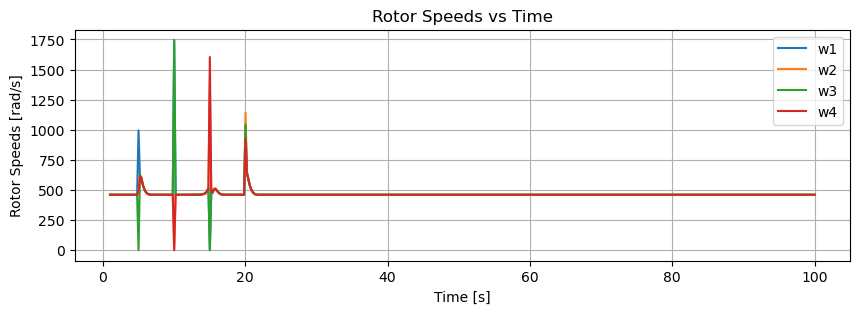

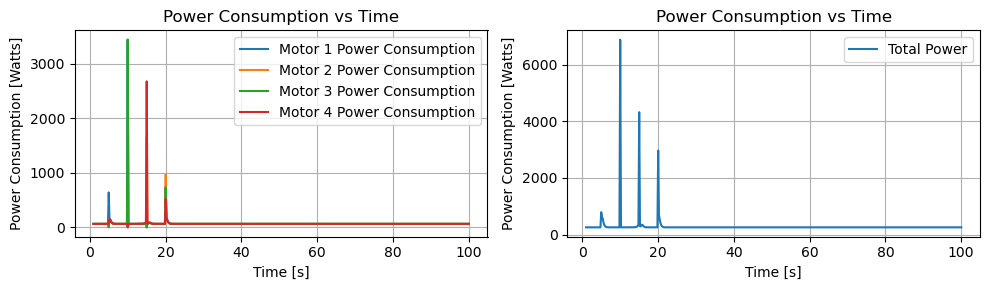

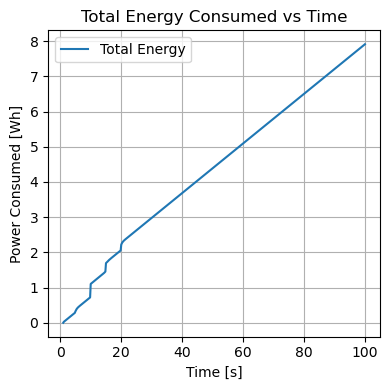

In [397]:
def controller(t, state, params):
    x, y, z = state[0], state[1], state[2]
    u, v, w = state[3], state[4], state[5]
    phi, theta, psi = state[6], state[7], state[8]
    p, q, r = state[9], state[10], state[11]


    if (t<5):
        x_ref = 0
        y_ref = 0
        z_ref = 1
        psi_ref = 0.0
    elif (t<10):
        x_ref = 5
        y_ref = 0
        z_ref = 1
        psi_ref = 0
    elif (t<15):
        x_ref = 5
        y_ref = 0
        z_ref = 1
        psi_ref = np.pi / 2
    elif t<20:
        x_ref = 5
        y_ref = 5
        z_ref = 1
        psi_ref = 0
    else:
        x_ref = 5
        y_ref = 0
        z_ref = 1
        psi_ref = 0
    # elif t<40:



    Kp_xy = 0.5
    Kd_xy = 0.3
    
    Kp_z = 0.5
    Kd_z = 100
    T = params['mass']*params['gravity'] + Kp_z*(z_ref - z) + Kd_z*(0 - w)
    a_des_x = Kp_xy*(x_ref - x) + Kd_xy*(0 - u)
    a_des_y = Kp_xy*( y_ref - y) + Kd_xy*(0 - v)
    # Linearization
    phi_des = -a_des_y
    theta_des = a_des_x

    Kp_angle = 200
    Kd_angle = 5

    # Compute torques
    tau_phi = Kp_angle*(phi_des - phi) + Kd_angle*(0 - p)
    tau_theta = Kp_angle*(theta_des - theta) + Kd_angle*(0 - q)
    tau_psi = Kp_angle*(psi_ref - psi) + Kd_angle*(0 - r)

    return [T, tau_phi, tau_theta, tau_psi]

def dynamics_with_control(t, state, params):
    input = controller(t, state, params)
    return dynamics(t, state, input, params)

centripetal_acceleration = 0.5**2 / R
downwards = params['mass'] * params['gravity']
ang = np.pi/2 - np.arctan2(downwards,centripetal_acceleration)
initial_state = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

t_span = (0, 100)
t_eval = np.linspace(0, 100, 500)
sol = solve_ivp(dynamics_with_control, t_span, initial_state, t_eval=t_eval, args=(params,))

x = sol.y[0,:]
y = sol.y[1,:]
z = sol.y[2,:]
phi = sol.y[6,:]
theta = sol.y[7,:]
psi = sol.y[8,:]

dphi = sol.y[9,:]
dtheta = sol.y[10,:]
dpsi = sol.y[11,:]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(x, y, label='Trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY Trajectory (Top View)')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(sol.t, np.degrees(phi), label='phi (roll)')
plt.plot(sol.t, np.degrees(theta), label='theta (pitch)')
plt.plot(sol.t, np.degrees(psi), label='psi (yaw)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.title('Angles vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d') 
ax.plot(x, y, z, label='3D Trajectory', color='blue')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('3D Trajectory (Top and Height View)')
ax.set_zlim(0, 1)
ax.grid(True)
ax.legend()

plt.show()

def compute_rotor_speeds_over_time(sol, params):
    """
    Using the solution 'sol' from solve_ivp and the given params, this function:
    - Calls the controller at each time step to get (T, tau_phi, tau_theta, tau_psi).
    - Computes the corresponding rotor speeds at each time.
    Returns time array and a 2D array of shape (4, len(sol.t)) with rotor speeds.
    """
    w_all = []
    for i, t in enumerate(sol.t):
        if t > 1:
            state = sol.y[:, i]
            T, tau_phi, tau_theta, tau_psi = controller(t, state, params)
            w = compute_rotor_speeds(T, tau_phi, tau_theta, tau_psi, params)
            w_all.append(w)
        else:
            w_all.append(np.array([1850,1850,1850,1850]))

    w_all = np.array(w_all).T 
    return sol.t, w_all[0,:], w_all[1,:], w_all[2,:], w_all[3,:]


def plot_rotor_speeds(t, w1, w2, w3, w4):
    """
    Plot rotor speeds for the four motors over time.
    """
    plt.figure(figsize=(10,3))
    plt.plot(t, w1, label='w1')
    plt.plot(t, w2, label='w2')
    plt.plot(t, w3, label='w3')
    plt.plot(t, w4, label='w4')
    plt.xlabel('Time [s]')
    plt.ylabel('Rotor Speeds [rad/s]')
    plt.title('Rotor Speeds vs Time')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_power(t, w1, w2, w3, w4):
    w = np.array([w1,w2,w3,w4])
    p_motors = []
    for i in range(len(w)):
        power = 0.13 * w[i]**3 * params['thrust_coefficient'] / 2
        p_motors.append(power)
    total = np.sum(p_motors, axis=0)


    energy_vals = np.cumsum(total) * (np.diff(t, prepend=t[0]) / 3600)

    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(t, p_motors[0], label='Motor 1 Power Consumption')
    plt.plot(t, p_motors[1], label='Motor 2 Power Consumption')
    plt.plot(t, p_motors[2], label='Motor 3 Power Consumption')
    plt.plot(t, p_motors[3], label='Motor 4 Power Consumption')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumption [Watts]')
    plt.title('Power Consumption vs Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(t, total, label='Total Power')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumption [Watts]')
    plt.title('Power Consumption vs Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4,4))
    plt.plot(t, energy_vals, label='Total Energy')
    plt.xlabel('Time [s]')
    plt.ylabel('Power Consumed [Wh]')
    plt.title('Total Energy Consumed vs Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

t, w1, w2, w3, w4 = compute_rotor_speeds_over_time(sol, params)
mask = t > 0.96
t = t[mask]
w1 = w1[mask]
w2 = w2[mask]
w3 = w3[mask]
w4 = w4[mask]
plot_rotor_speeds(t, w1, w2, w3, w4)
plot_power(t, w1, w2, w3, w4)